In [148]:
import pandas as pd 
import matplotlib.pyplot as plt
import os
import numpy as np

In [149]:
data = "./data"
train_path = os.path.join(data, "train")
val_path = os.path.join(data, "valid")
test_path = os.path.join(data, "test")

In [150]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [151]:
# data = ImageDataGenerator(
#     rescale = 1./255,
#     brightness_range = (0.2,0.4),
#     rotation_range = 0.2,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     horizontal_flip = True,
#     vertical_flip = True,
# )

# train_df = data.flow_from_directory(
#     train_path,
#     batch_size = 64,
#     target_size = (225,225),
#     shuffle = True,
#     class_mode = 'categorical'
# )
# val_df = data.flow_from_directory(
#     val_path,
#     batch_size = 64,
#     target_size = (225,225),
#     shuffle = True,
#     class_mode = 'categorical'
# )

In [152]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [153]:
le = LabelEncoder()
le.fit(['no_vector','vector'])

annotations_path = os.path.join(train_path,"_annotations.csv")
annotations_df = pd.read_csv(annotations_path)
annotations_df['class'] = le.transform(annotations_df['class'])

train_images = []
train_target = []
train_label = []

for index, row in annotations_df.iterrows():
    (filename, width, height, class_name, x_min, y_min, x_max, y_max) = row
    train_image_path = os.path.join(train_path,filename)
    train_img = load_img(train_image_path, target_size = (225,225), color_mode = 'grayscale')
    train_img_array = img_to_array(train_img)

    x_min = round(x_min/width,2)
    y_min = round(y_min/height,2)
    x_max = round(x_max/width,2)
    y_max = round(y_max/height,2)

    train_images.append(train_img_array)
    train_target.append((x_min, y_min,x_max,y_max))
    train_label.append(class_name)




### validation

In [154]:

le = LabelEncoder()
le.fit(['no_vector','vector'])

annotations_path = os.path.join(val_path,"_annotations.csv")
annotations_df = pd.read_csv(annotations_path)
annotations_df['class'] = le.transform(annotations_df['class'])

validation_images = []
validation_target = []
validation_label = []

for index, row in annotations_df.iterrows():
    (filename, width, height, class_name, x_min, y_min, x_max, y_max) = row
    val_image_path = os.path.join(val_path,filename)
    val_img = load_img(val_image_path, target_size = (225,225),color_mode = 'grayscale')
    val_img_array = img_to_array(val_img)

    x_min = round(x_min/width,2)
    y_min = round(y_min/height,2)
    x_max = round(x_max/width,2)
    y_max = round(y_max/height,2)

    validation_images.append(val_img_array)
    validation_target.append((x_min, y_min,x_max,y_max))
    validation_label.append(class_name)




In [155]:
train_images = np.array(train_images)
train_target = np.array(train_target)
train_label = np.array(train_label)

validation_images = np.array(validation_images)
validation_target = np.array(validation_target)
validation_label = np.array(validation_label)

In [156]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Rescaling, InputLayer, Input

input_layer = Input(shape=train_images[0].shape)
x = Rescaling(1./255)(input_layer)
x = Conv2D(32, (3, 3),padding = 'same', activation='relu')(x)
x = MaxPooling2D((3, 3))(x)
x = Conv2D(64, (3, 3),padding = 'same', activation='relu')(x)
x = MaxPooling2D((3, 3))(x)
x = Conv2D(128, (3, 3),padding = 'same', activation='relu')(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)

# Cabang untuk klasifikasi
classification_output = Dense(2, activation='softmax', name='classification_output')(x)

# Cabang untuk bounding box
bounding_box_output = Dense(4, name='bounding_box_output')(x)

model = Model(inputs=input_layer, outputs=[classification_output, bounding_box_output])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 225, 225, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 225, 225, 1)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 225, 225, 32  320         ['rescaling_4[0][0]']            
                                )                                                                 
                                                                                            

In [157]:
import tensorflow as tf

losses = {"classification_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bounding_box_output": tf.keras.losses.MeanSquaredError()}
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [158]:
trainTargets = {
    "classification_output": train_label,
    "bounding_box_output": train_target
}
validationTargets = {
    "classification_output": validation_label,
    "bounding_box_output": validation_target
}

history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             epochs=10,
             shuffle=True,
             verbose=1)

Epoch 1/10


c:\Users\untu0\anaconda3\envs\TF-GPU\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 2s 64ms/step - loss: 1.2559 - classification_output_loss: 0.1414 - bounding_box_output_loss: 1.1145 - classification_output_accuracy: 0.9883 - bounding_box_output_accuracy: 0.4167 - val_loss: 0.1692 - val_classification_output_loss: 0.0056 - val_bounding_box_output_loss: 0.1636 - val_classification_output_accuracy: 1.0000 - val_bounding_box_output_accuracy: 0.1455
Epoch 2/10
19/19 [==============================] - 1s 47ms/step - loss: 0.0394 - classification_output_loss: 3.6051e-04 - bounding_box_output_loss: 0.0391 - classification_output_accuracy: 1.0000 - bounding_box_output_accuracy: 0.8183 - val_loss: 0.0781 - val_classification_output_loss: 0.0071 - val_bounding_box_output_loss: 0.0710 - val_classification_output_accuracy: 1.0000 - val_bounding_box_output_accuracy: 0.8364
Epoch 3/10
19/19 [==============================] - 1s 48ms/step - loss: 0.0163 - classification_output_loss: 4.9337e-04 - bounding_box_output_loss: 0.0158 - classificat

In [159]:
train_images.shape

(600, 225, 225, 1)

In [160]:
test_img = []
for list_name in os.listdir(test_path):
    if list_name.endswith(('jpg')):
        img_path = os.path.join(test_path, list_name)
        img = load_img(img_path, target_size=(225,225), color_mode="grayscale")
        img_array = img_to_array(img)
        test_img.append(img_array)

In [161]:
test_images = np.array(test_img)

In [162]:
pred = model.predict(test_images)

1/1 [==============================] - 0s 167ms/step


In [163]:
import cv2

1/1 [==============================] - 0s 21ms/step


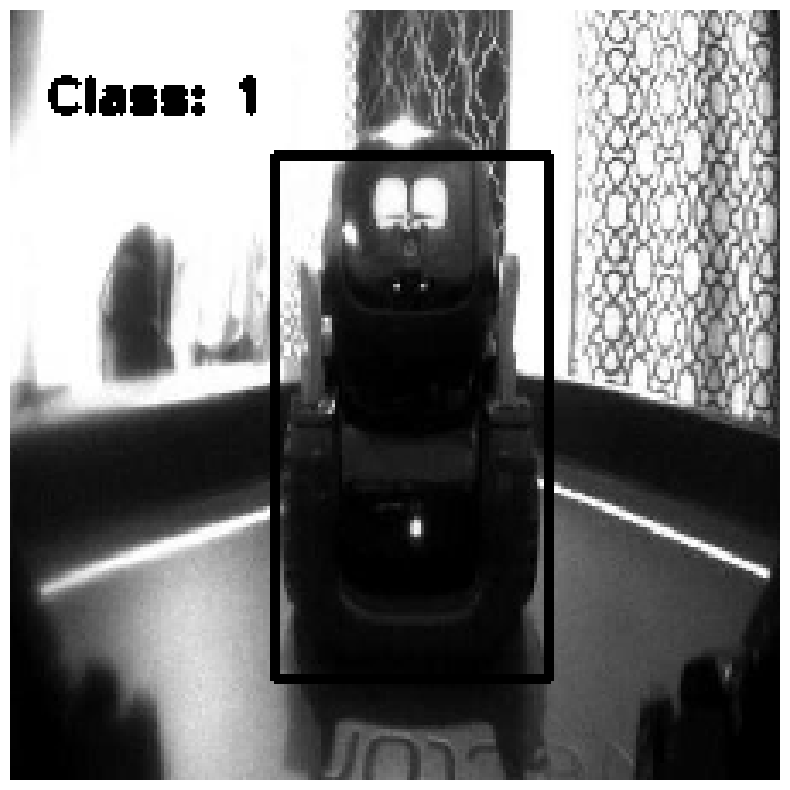

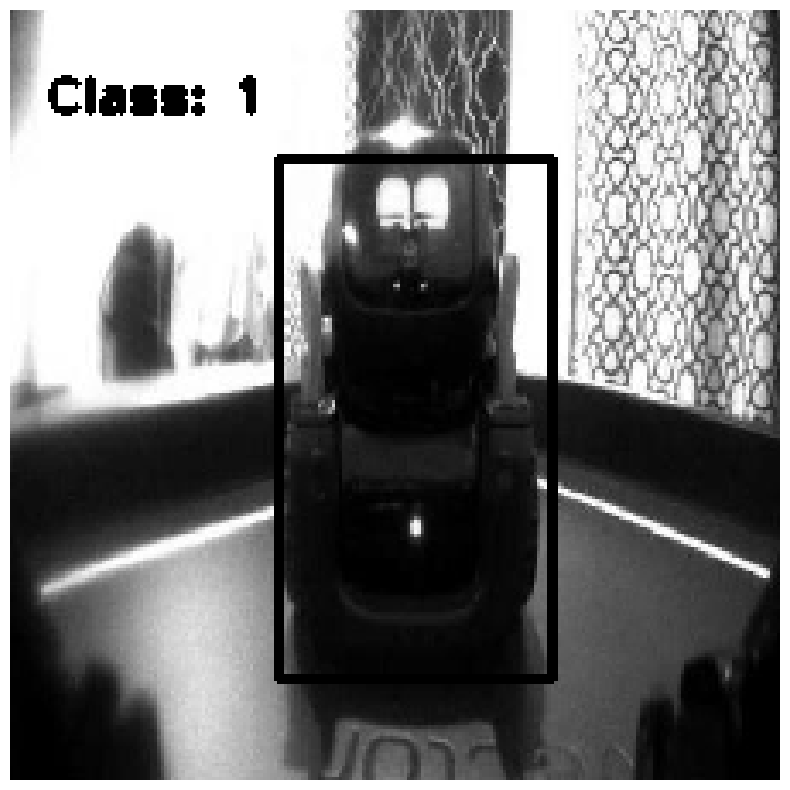

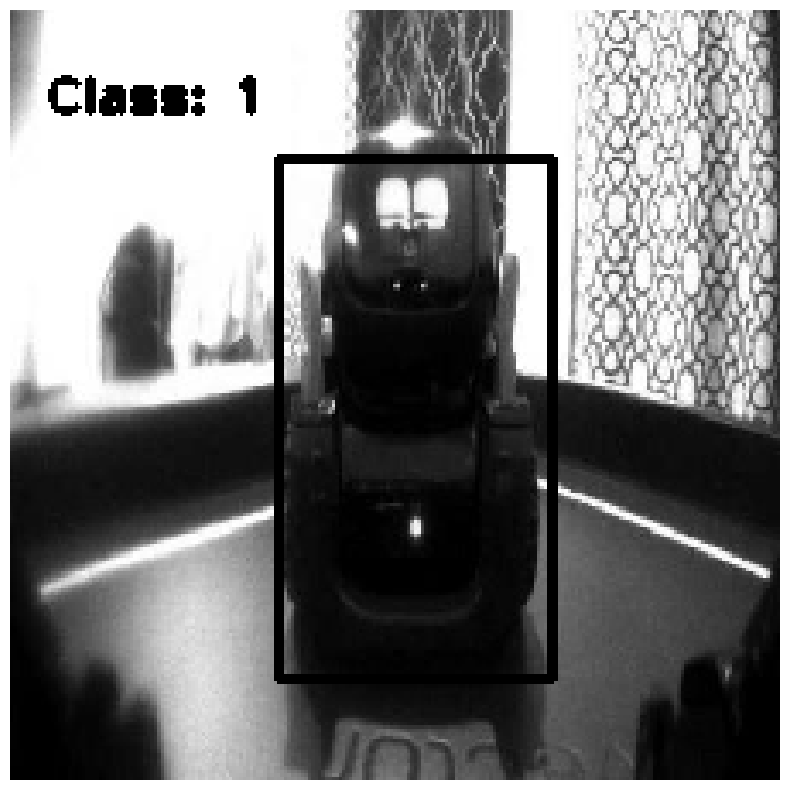

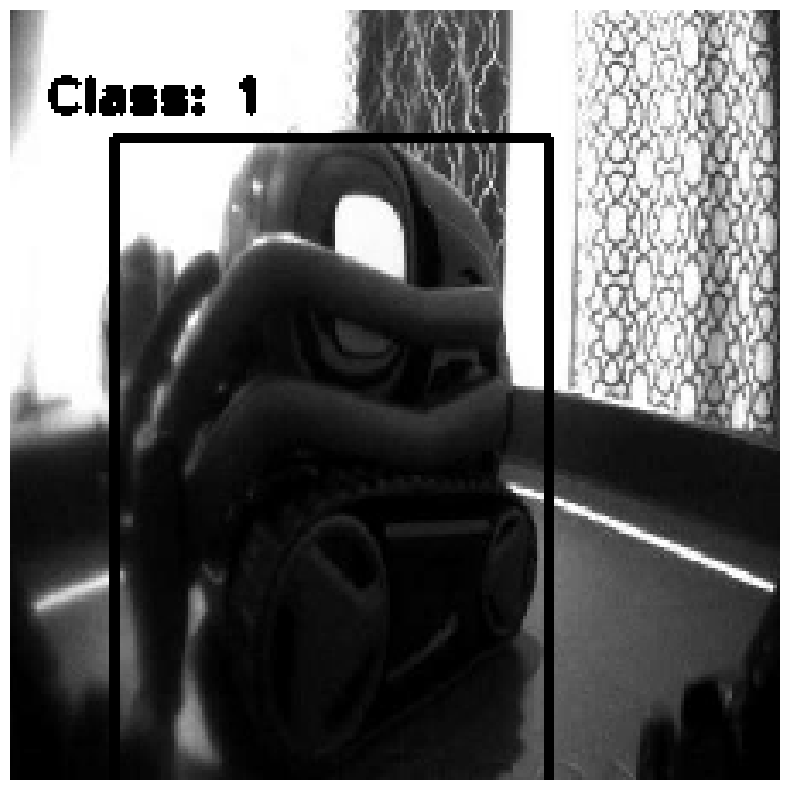

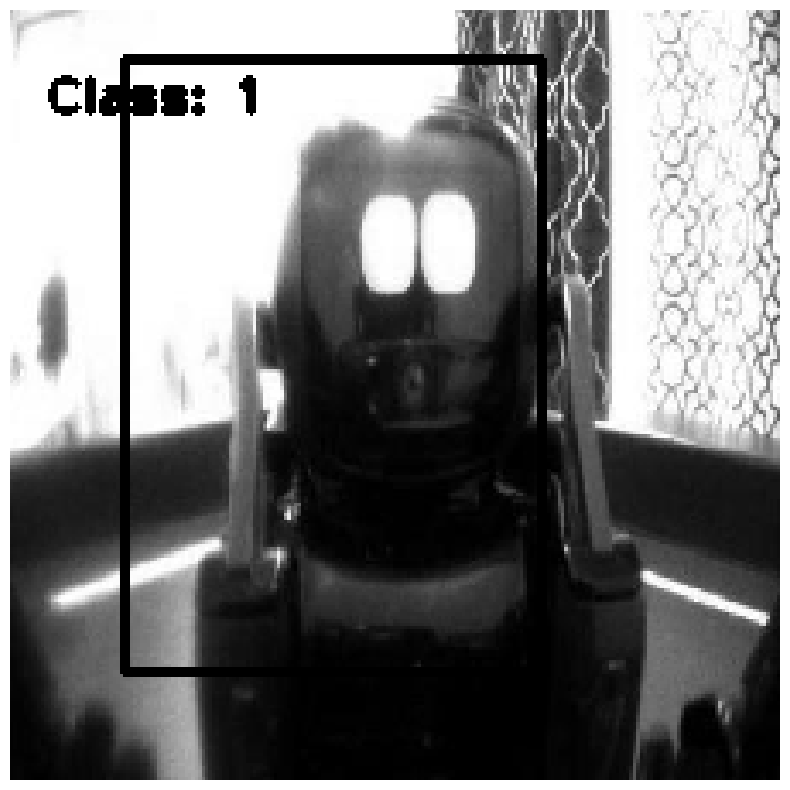

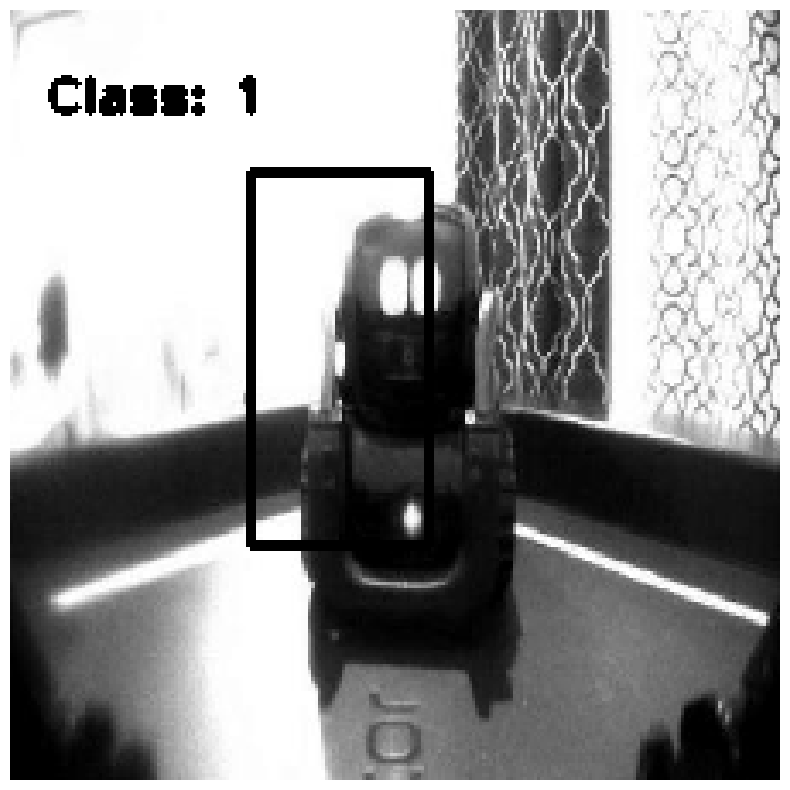

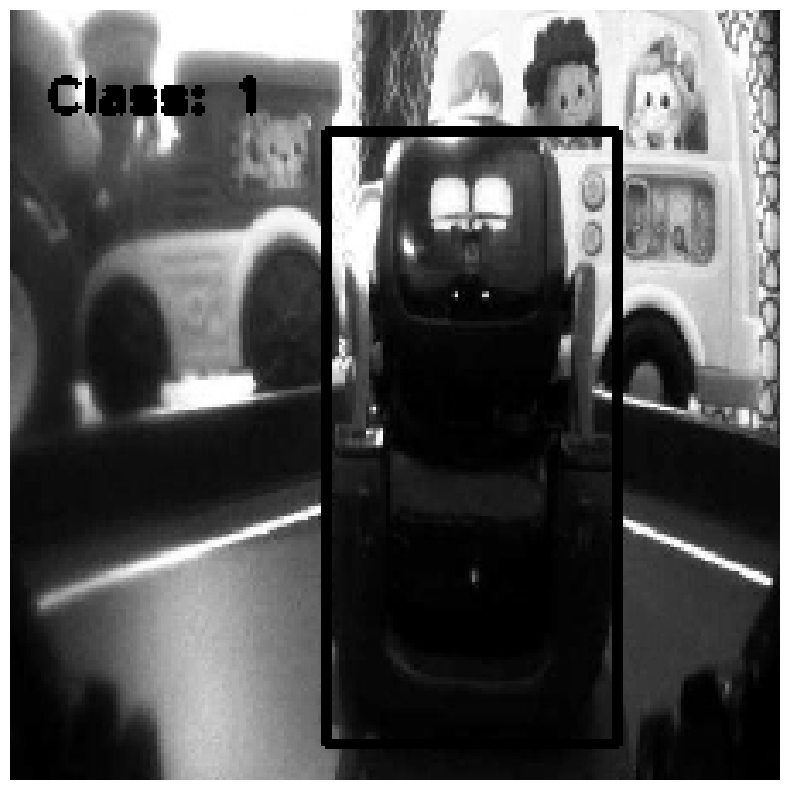

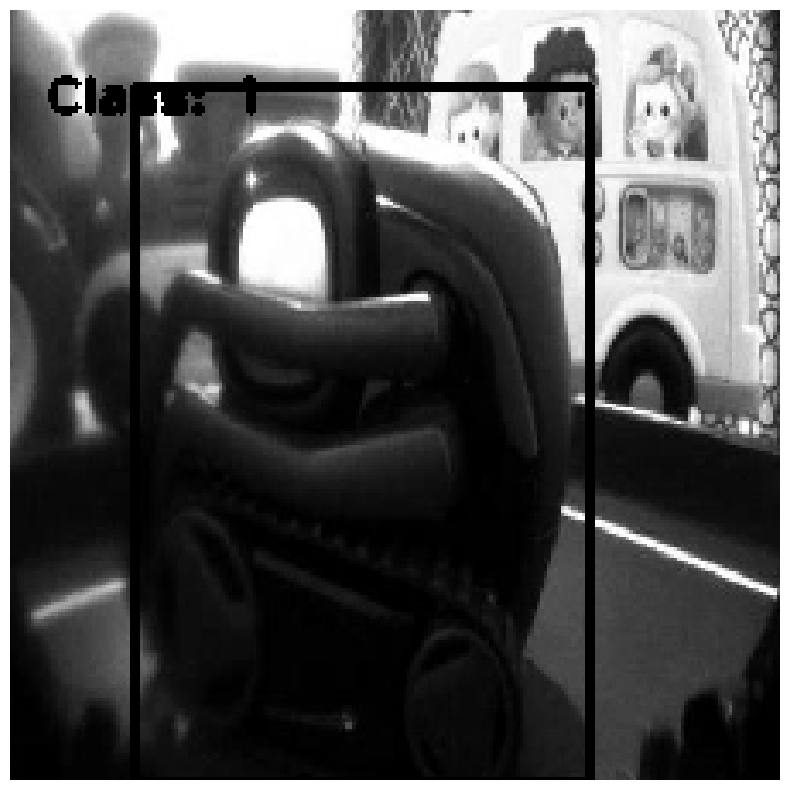

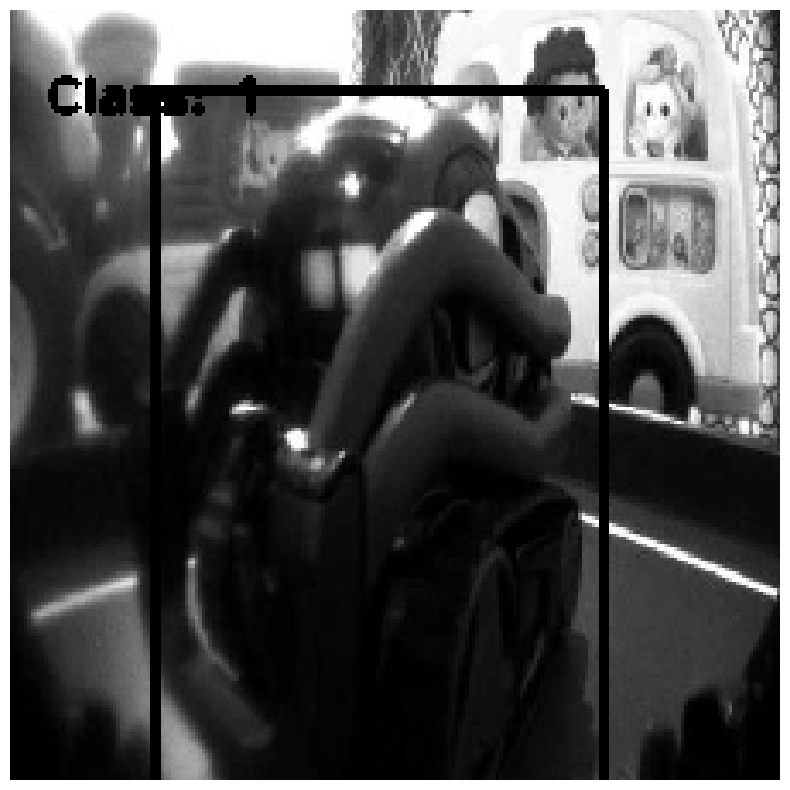

In [165]:
# Membuat bounding box pada objek menggunakan cv2
import matplotlib.pyplot as plt
import numpy as np

height = test_images[0].shape[0]
width = test_images[0].shape[1]
pred = model.predict(test_images)
# Memisahkan hasil prediksi untuk klasifikasi dan bounding box
pred_class, pred_box = pred

for i in range(9):
    img = test_images[i].copy()
    class_pred = pred_class[i]
    box_pred = pred_box[i]
    
    x_min, y_min, x_max, y_max = int(box_pred[0] * width), int(box_pred[1] * height), int(box_pred[2] * width), int(box_pred[3] * height)
    
    # Menggambar bounding box
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    # Menampilkan hasil klasifikasi
    class_label = np.argmax(class_pred)
    cv2.putText(img, f"Class: {class_label}", (10, 30), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 2)
    
    # Menampilkan gambar
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.show()